In [160]:
!pip install antigranular --upgrade

In [147]:
import antigranular as ag
session = ag.login(<client_id>,<client_secret>, dataset = "Adult Population Dataset")

Connected to Antigranular server session id: aaef2001-1aa5-41b4-a9a0-d0aaa5464e11
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server


In [148]:
%%ag
from op_pandas import PrivateDataFrame, PrivateSeries
from ag_utils import load_dataset, export, submit_predictions

response = load_dataset("Adult Population Dataset")

train_x = response["train_x"]
train_y = response["train_y"]
test_x = response["test_x"]

The goal of this notebook is to predict whether income exceeds $50K/yr based on census data. However the data is confidential, therefore we have to apply techniques from Differential Privacy in order to get insights from the data and build classification models. We will show how to use Antigranular to achieve this result!

In [4]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt


In [5]:
%%ag
from typing import Any
# encoding categoricals
def label_encode(x:str)-> int:
  if x == '>50K':
    return 0
  elif x == '<=50K':
    return 1

train_y_encoded = train_y.applymap(label_encode , output_bounds={'income':(0,1)})

In [6]:
%%ag
train_xy = train_x.join(train_y_encoded, how="inner")

In [20]:
%%ag
export(train_xy.describe(eps=1), "descr_initial_df")

Total epsilon spent = 1.0000

Setting up exported variable in local environment: descr_initial_df


In [21]:
descr_initial_df

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income
count,39027.000000,3.902700e+04,39027.000000,39027.000000,39027.000000,39027.000000,39027.000000
mean,38.552124,1.889283e+05,10.074270,1027.264957,84.153959,40.565899,0.762417
std,13.552442,2.360801e+04,2.553931,3609.737627,457.983516,12.722783,0.424453
min,17.950626,1.847939e+04,1.592024,801.390141,160.592626,0.280560,0.652964
25%,27.169852,1.173110e+05,8.469911,360.297001,1273.347490,39.283841,0.771650
50%,37.160457,1.778268e+05,9.045377,5.981458,109.726482,40.932206,0.025577
75%,47.505859,2.365982e+05,12.312016,121.334360,139.843316,46.525077,0.731120
max,85.729975,1.346618e+06,15.329910,51522.551204,4332.950169,81.421181,0.701572


In [7]:
%%ag
data_for_hist = train_y_encoded['income'].sum(eps=1)
export(data_for_hist, 'data_for_hist')

Setting up exported variable in local environment: data_for_hist


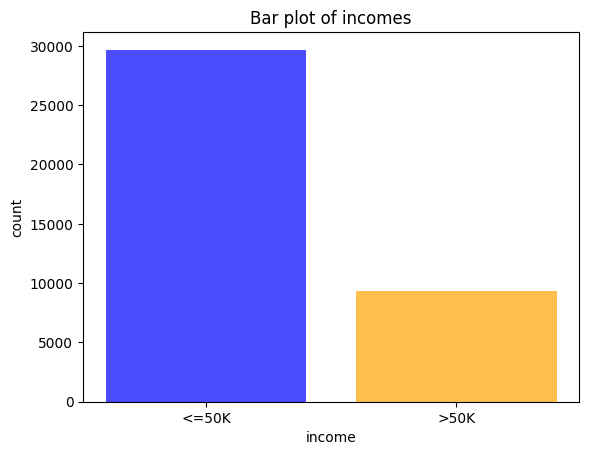

In [22]:
income_leq50K = data_for_hist
n_obs_income = 39027
income_grt50K = n_obs_income - income_leq50K

# Create a bar plot
plt.bar(['<=50K', '>50K'], [income_leq50K, income_grt50K], color=['blue', 'orange'], alpha = 0.7)

# Add labels and title
plt.xlabel('income')
plt.ylabel('count')
plt.title('Bar plot of incomes')

# Show the plot
plt.show()



Notice that majority of the observations make less than $50,000 a year


Observe that we have the following type of features (this is public information in the page of the dataset: https://www.antigranular.com/dataset/64abecde30b8344f8d168c0d)

Numerical features:
 ['age' 'fnlwgt' 'educational-num' 'capital-gain' 'capital-loss'
 'hours-per-week']

Categorical features:
 ['workclass' 'education' 'marital-status' 'occupation' 'relationship'
 'race' 'gender' 'native-country' 'income']


We observe that some of the variables are not self-explanatory. The continuous variable "fnlwgt" represents final weight, which is the number of units in the target population that the responding unit represents. Moreover, the variable "education_num" stands for the number of years of education in total, therefore it is a continuous representation of the discrete variable "education". The variable "relationship" represents the responding unit’s role in the family. "capital_gain" and "capital_loss" are income from investment sources other than wage/salary.

For simplicity of this analysis, the weighting factor is discarded. Total number of years of education can represent by the highest education level completed. Role in the family can be assessed from gender and marital status. Thus, the columns corresponding to the following 6 variables are not considered in the analysis: "education", "relationship", and "fnlwgt", "race, "native-country", "occupation".


First, we transform into numeric the categorical variables, in order to be able to use all the functionalities of Antigranular and the libraries supported, like training the classification model. We must spend a bit of privacy budget to convert some categorical variables into a numerical ones, so that we can study them.


In [9]:
%%ag
import pandas as pd
df = PrivateDataFrame(pd.DataFrame({}))

In [10]:
%%ag
df[["age", "educational-num", "capital-gain", "capital-loss", "hours-per-week", "income"]] = train_xy[["age", "educational-num", "capital-gain", "capital-loss", "hours-per-week", "income"]]


In [11]:
%%ag
def gender_encode(x:str)-> int:
  if x == 'Male':
    return 1
  elif x == 'Female':
    return 0

train_x_gender = train_x.applymap(gender_encode , output_bounds={'gender':(0,1)})

In [12]:
%%ag
df[ "gender"]=train_x_gender["gender"]

In [13]:
%%ag
import op_snsql

In [36]:
%%ag
privacy = op_snsql.Privacy(epsilon=3.0 , delta=0.1)
reader_gender = op_snsql.from_df(df=df, privacy=privacy)


In [37]:
%%ag
count_male = reader_gender.execute(f"SELECT COUNT(gender) as n_males from df.table WHERE gender = 1")
count_female = reader_gender.execute(f"SELECT COUNT(gender) as n_females from df.table WHERE gender = 0")
result_male = reader_gender.execute(f"SELECT COUNT(gender) as male_gtr50 from df.table WHERE gender = 1 AND income = 0")
result_female = reader_gender.execute(f"SELECT COUNT(gender) as female_gtr50 from df.table WHERE gender = 0 AND income = 0")

export(str(count_male) , 'n_m')
export(str(count_female) , 'n_f')
export(str(result_female) , 'result_f')
export(str(result_male) , 'result_m')
export(str(result_female) , 'result_f')

Setting up exported variable in local environment: n_m
Setting up exported variable in local environment: n_f
Setting up exported variable in local environment: result_f
Setting up exported variable in local environment: result_m
Setting up exported variable in local environment: result_f


In [38]:
print(n_m, n_f, result_m, result_f)

[['n_males'], [26140]] [['n_females'], [12934]] [['male_gtr50'], [7961]] [['female_gtr50'], [1436]]


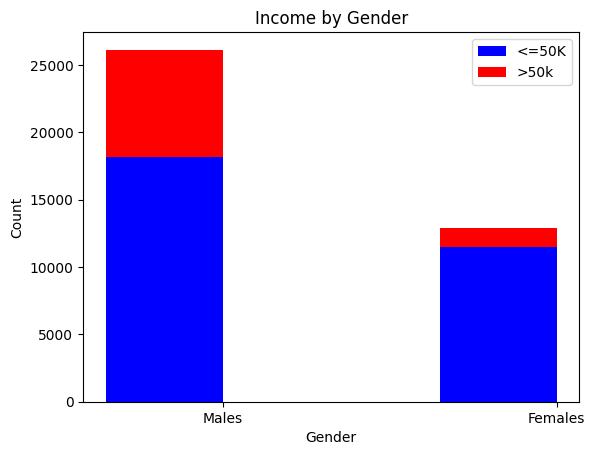

In [142]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your actual values
z_values = [7960, 1436]  # y values for the two bars
y_values = [26140-7960, 12934-1436]  # z values for the two bars

labels = ['Males', 'Females']  # Labels for the two bars
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

# Create the bars for 'y'
bars_y = ax.bar(x - width/2, y_values, width, label='<=50K', color='blue')

# Create the bars for 'z' on top of 'y'
bars_z = ax.bar(x - width/2, z_values, width, bottom=y_values, label='>50k', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Income by Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()


Interestingly, females are underrepresented. This could be possibly caused by census bias.



In [44]:
%%ag
def workclass_encode(x:str)-> int:

  if x == 'Private':
    return 4
  elif x == 'Self-emp-not-inc':
    return 6
  elif x == 'Self-emp-inc':
    return 5
  elif x == 'Federal-gov':
    return 1
  elif x == 'Local-gov':
    return 2
  elif x == 'Without-pay':
    return 8
  elif x == 'State-gov':
    return 7
  elif x == 'Never-worked':
    return 3
  else:
    return 0
train_x_workclass= train_x.applymap(workclass_encode, eps=0.5, output_bounds={'workclass':(0,8)})

Kernel interrupted successfully


Let's see in more details the "workclass" variable.

In [46]:
%%ag
privacy = op_snsql.Privacy(epsilon=8.0 , delta=0.08)
reader_workclass = op_snsql.from_df(df=train_x, privacy=privacy)


In [50]:
%%ag
c0 = reader_workclass.execute("SELECT COUNT(workclass) as Private from df.table WHERE workclass =='Private' ")
c1 = reader_workclass.execute("SELECT COUNT(workclass) as Selfempnotinc from df.table WHERE workclass == 'Self-emp-not-inc' ")
c2 = reader_workclass.execute("SELECT COUNT(workclass) as Selfempinc from df.table WHERE workclass == 'Self-emp-inc' ")
c3 = reader_workclass.execute("SELECT COUNT(workclass) as Federalgov from df.table WHERE workclass == 'Federal-gov' ")
c4 = reader_workclass.execute("SELECT COUNT(workclass) as Localgov from df.table WHERE workclass == 'Local-gov' ")
c5 = reader_workclass.execute("SELECT COUNT(workclass) as Withoutpay from df.table WHERE workclass == 'Without-pay' ")
c6 = reader_workclass.execute("SELECT COUNT(workclass) as Stategov from df.table WHERE workclass == 'State-gov' ")
c7 = reader_workclass.execute("SELECT COUNT(workclass) as Neverworked from df.table WHERE workclass == 'Never-worked' ")

export(str([c0, c1, c2, c3, c4, c5, c6, c7]), "counts_workclass")


Setting up exported variable in local environment: counts_workclass


In [51]:
counts_workclass

"[[['Private'], [27122]], [['Selfempnotinc'], [3061]], [['Selfempinc'], [1377]], [['Federalgov'], [1145]], [['Localgov'], [2499]], [['Withoutpay'], [18]], [['Stategov'], [1578]], [['Neverworked'], [9]]]"

Notice that there are two small groups: – Never-worked and Without-pay. We will combine them with Unknowns into a group called Other/Unknown. Those who work in the government are further break down into federal, state, and local levels. To facilitate the analysis, I group them into one group called Government. While those who are self-employed fall into two groups, incorporated and not incorporated, and are grouped into Self-Employed.

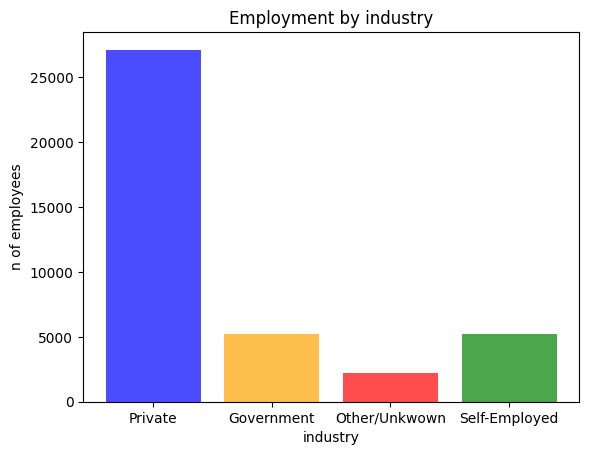

In [52]:
private_work = 27122
n_obs = n_obs_income
self_employed = 3061 + 1377
government = 1145 + 2499 + 1577
other = n_obs - (private_work + self_employed + government)

# Create a bar plot
plt.bar(['Private', 'Government', 'Other/Unkwown', 'Self-Employed'], [private_work, government, other, government], color=['blue', 'orange', 'red', 'green'], alpha = 0.7)

# Add labels and title
plt.xlabel('industry')
plt.ylabel('n of employees')
plt.title('Employment by industry')

# Show the plot
plt.show()



In [53]:
%%ag
def workclass_final_encode(x:str)-> int:

  if x == 'Private':
    return 1
  elif x == 'Self-emp-not-inc' or 'Self-emp-inc':
    return 3
  elif x == 'Federal-gov' or 'Local-gov' or 'State-gov':
    return 2
  else: # includes Never-worked and Without-pay and other Nans, etc
    return 0
train_x_workclass_def= train_x.applymap(workclass_encode, eps=0.5, output_bounds={'workclass':(0,3)})

Setting up exported variable in local environment: counts_workclass


Thus, there are now four categories for the variable workclass.


In [54]:
%%ag
df[ "workclass"]=train_x_workclass_def["workclass"]

In [61]:
%%ag
privacy = op_snsql.Privacy(epsilon=4.0 , delta=0.04)
reader_workclass_def = op_snsql.from_df(df=df, privacy=privacy)


In [62]:
%%ag
c0_priv = reader_workclass_def.execute("SELECT COUNT(workclass) as Private from df.table WHERE workclass ==1 AND income == 0 ")
c1_self = reader_workclass_def.execute("SELECT COUNT(workclass) as Selfemp from df.table WHERE workclass == 3 AND income == 0")
c2_gov = reader_workclass_def.execute("SELECT COUNT(workclass) as Gov from df.table WHERE workclass == 2 AND income == 0")
c3_oth= reader_workclass_def.execute("SELECT COUNT(workclass) as Other from df.table WHERE workclass == 0 AND income == 0")

export(str([c0_priv, c1_self, c2_gov, c3_oth]), "counts_gtr50")


Setting up exported variable in local environment: counts_gtr50


In [63]:
counts_gtr50

"[[['Private'], [473]], [['Selfemp'], [7979]], [['Gov'], [734]], [['Other'], [212]]]"

In [ ]:
private_work = 27122
n_obs = n_obs_income
self_employed = 3061 + 1377
government = 1145 + 2499 + 1577
other = n_obs - (private_work + self_employed + government)


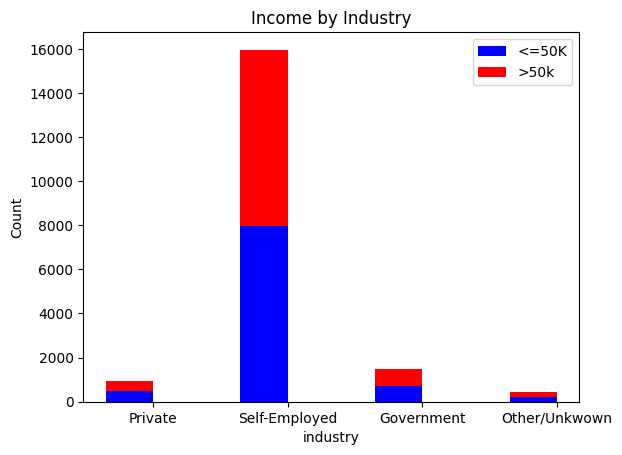

In [65]:
# Replace these with your actual values
z_values = [473, 7979, 734, 211]  # y values for the four bars
Y_values = [private_work-473, self_employed-7979, government-734, other-211]  # z values for the four bars

labels = ['Private', 'Self-Employed', 'Government', 'Other/Unkwown']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

# Create the bars for 'y'
bars_y = ax.bar(x - width/2, y_values, width, label='<=50K', color='blue')

# Create the bars for 'z' on top of 'y'
bars_z = ax.bar(x - width/2, z_values, width, bottom=y_values, label='>50k', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('industry')
ax.set_ylabel('Count')
ax.set_title('Income by Industry')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()


TODO: THERE'S SOMETHING WRING WITH THIS PLOT (LIKE THE COLS ARE SWITCHED...)

Observe that those who are self employed seem to have the highest tendency of making greater than $50,000 a year.



Now, we finish the construction the definitive dataset with which we will work.

We convert the remaining categorical variables into numerical ones.
We start with "marital-status". "marital_status" is a categorical variable with 7 categories indicating the marital status of observations. However, as in the case of "workclass", for simplicity, it can be blocked into a few categories as well.



In [66]:
%%ag
def marital_status_encode(x:str)-> int:

  if x == 'Married-civ-spouse' or 'Married-AF-spouse' or 'Married-spouse-absent':
    return 4
  elif x == 'Divorced':
    return 3
  elif x == 'Widowed':
    return 2
  elif x == 'Separated':
    return 1
  else: # Single = Never-married + other
    return 0

train_x_marital = train_x.applymap(marital_status_encode, eps=0.5, output_bounds={'marital-status':(0,4)})

We know define the dataset with which we will finally work

In [67]:
%%ag
df["marital-status"] = train_x_marital["marital-status"]

Therefore, the definitive dataframe is called "df" and we can see an overview of it by:

In [68]:
%%ag
export(df.describe(eps=1), "description_df")

Total epsilon spent = 1.0000

Setting up exported variable in local environment: description_df


In [69]:
description_df

,age,educational-num,capital-gain,capital-loss,hours-per-week,income,gender,workclass,marital-status
count,39073.000000,39073.000000,39073.000000,39073.000000,39073.000000,39073.000000,39073.000000,39073.000000,39073.000000
mean,38.819400,10.055820,1365.715946,92.363053,40.190647,0.760606,0.669579,2.691025,3.999083
std,15.381747,2.536135,5499.520742,451.572578,10.156838,0.421943,0.469781,0.786451,0.241034
min,17.299280,1.272477,209.822959,30.717592,3.124095,0.979441,0.934728,0.014035,1.634489
25%,27.490189,8.376753,330.591108,682.162995,38.173104,0.231820,0.154068,2.718341,0.166139
50%,36.797130,9.411683,1758.109871,617.901386,41.001884,0.154293,0.275054,2.705757,2.767870
75%,47.082926,12.538960,769.604828,1325.117619,44.876313,0.559087,0.766345,2.937792,1.052169
max,79.287625,15.854033,49539.578332,3355.117817,80.268867,0.160223,0.926814,2.045151,0.907970


We also look at the correlation (private) between the covariables and the label we want to predict.

In [70]:
%%ag
priv_corr = df.corr(eps=9)
export(priv_corr , 'priv_corr')

Setting up exported variable in local environment: priv_corr


<Axes: >

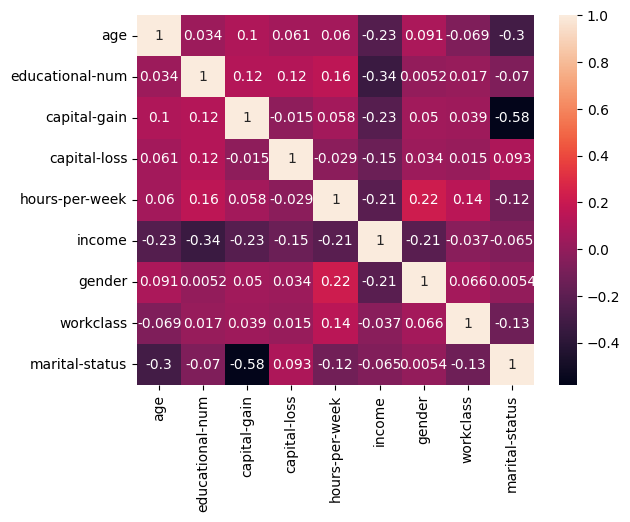

In [72]:
result = priv_corr.apply(pd.to_numeric, errors='coerce').astype(float)
sb.heatmap(result , annot = True)

It looks like the strongest correlations are between education, age and martial-status (with income).

Model Fitting – Logistic Regression


In [73]:
%%ag
from op_diffprivlib.models import LogisticRegression

In [74]:
%%ag
export(df.columns, "def_cols")

Setting up exported variable in local environment: def_cols


In [75]:
def_cols

Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income', 'gender', 'workclass', 'marital-status'],
      dtype='object')

In [86]:
%%ag
x_training = df[['age', 'workclass', 'educational-num','marital-status', 'gender', 'capital-gain', 'capital-loss',
       'hours-per-week']]
y_training = df['income']

In [77]:
%%ag
train_x_2 = x_training ** 2
l_2_norm = train_x_2.sum(axis = 1) ** 0.5
l_2_norm = l_2_norm.quantile(1, eps=1)    # dp_max(sum(x**2, 1)**0.5)

In [88]:
%%ag
logr = LogisticRegression(epsilon = 10, data_norm = l_2_norm)
logr.fit(x_training, y_training)


We prepare the test data for the predictions

In [133]:
%%ag
testing_x = test_x[['age', 'workclass', 'educational-num','marital-status', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week']]

In [134]:
%%ag
testing_x["workclass"]= test_x["workclass"].map(workclass_final_encode)

/tmp/ipykernel_27181/3202330002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_x["workclass"]= test_x["workclass"].map(workclass_final_encode)



In [135]:
%%ag
testing_x["gender"]= test_x["gender"].map(gender_encode)


/tmp/ipykernel_27181/2690738465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_x["gender"]= test_x["gender"].map(gender_encode)



In [136]:
%%ag
testing_x['marital-status'] = test_x['marital-status'].map(marital_status_encode)

/tmp/ipykernel_27181/2024555110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_x['marital-status'] = test_x['marital-status'].map(marital_status_encode)



In [141]:
%%ag
from ag_utils import submit_predictions
result = submit_predictions(test_y)
import numpy as np
import pandas as pd
df_pred = pd.DataFrame(np.zeros(shape=(9769, 1)))
result = submit_predictions(df_pred)



---------------------------------------------------------------------------AttributeError                            Traceback (most recent call last)Cell In[88], line 1
----> 1 from ag_utils import submit_predictions
      2 result = submit_predictions(test_y)
File /code/dependencies/ag-utils/ag_utils/submit_predictions.py:6, in submit_predictions(data)
      5 def submit_predictions(data: pd.DataFrame) -> None: 
----> 6     request_df_json = BaseSubmitPredictionsRequest(data=data.to_json())
      7     req_obj = BaseRequestWrapper(request=request_df_json, request_type="submit_predictions")
      9     response = input(req_obj.json())
AttributeError: 'numpy.ndarray' object has no attribute 'to_json'
